In [1]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import pickle

C:\Users\rodri\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rodri\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\rodri\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rodri\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Embedding Model

### Load Data

The data consist on a curated list of news headline. There are news in english and portuguese, for now I've opt to keep the model as a multilanguage model.

In [220]:
df = pd.read_csv('data\dados_treinamento.csv', delimiter=';')
df.head()

,headline,analytics
0,"A computação pode ser de borda, mas a seguranç...",1
1,"A IA e as ciências sociais já foram próximas, ...",1
2,A Nova Era Dos Negócios: A Importância Dos Dad...,1
3,A revoluçãoo da Justiça com o Big Data,1
4,A vez da inteligência artificial na medicina,1


As we can see, the data is a kind balanced, so we don`t have to worry about it for now

In [3]:
df.groupby('analytics').count()

,headline
analytics,
0,940
1,1052


Also, there aren`t NaNs

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   1992 non-null   object
 1   analytics  1992 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.2+ KB


### Text Processing

Since I work a lot with text processing, I've made a class to handle this job. 

This class remove Stopwords, lowecase, strip accents, do word stemming, some replaces and tokenize the text.

In [5]:
import unicodedata
import re
from gensim.parsing.preprocessing import preprocess_string

class Processor:
    def __init__(self, stopwords: list = []):
        
        with open('utils\stop_words_english.txt', 'r') as eng:
            stopwords = eng.readlines()
            
        with open('utils\stop_words_portuguese.txt', 'r') as pt:
            stopwords = stopwords + pt.readlines()
        
        stopwords = list(map(self.clean_txt, stopwords))
        
        stop_words_add = 'segundafeira tercafeira quartafeira quintafeira sextafeira sabado domingo de em e para na dia dias ainda maior milhões além ser sobre nesta disse outro mil deve semana dezembro janeiro novembro grande anterior diz ter pode três meses assim vai quase após cada ano todo agora número apenas sendo disso mês podem alguma desse devido ante quanto todo enquanto outra onde porque dois têm desde todos vem apesar outras deste devem algumas então toda tanto entanto porém neste vez uma seu como tem'
        for word in stop_words_add.split(" "): stopwords.append(word)
        self.stop_words = stopwords

    def clean_txt(cls, txt):
        return txt.replace('\n', '')
        
    @classmethod
    def strip_accents(cls, s):
        # Removes accents in words
        return ''.join(c for c in unicodedata.normalize('NFD', s)
                       if unicodedata.category(c) != 'Mn')

    def text_process(self, text_corpus, word_len: int = 1):
        # remove \n, punctuation and what else needed
        text_corpus = re.sub(r'(\\n)', " ", text_corpus).strip()
        text_corpus = re.sub(r'[^\w\s]', " ", text_corpus).strip()
        text_corpus = text_corpus.replace('insidebigdat latest new', '')
        text_corpus = re.sub('5g', 'cincoginternet', text_corpus, count=0, flags=re.IGNORECASE)
        text_corpus = re.sub('6g', 'seisG', text_corpus, count=0, flags=re.IGNORECASE)
        text_corpus = re.sub('industria 4.0', 'industriaquatropontozero', text_corpus, count=0, flags=re.IGNORECASE)
        text_corpus = re.sub('MAPA', 'MinisterioAgriculturaPecuariaAbastecimento', text_corpus)
        text_corpus = re.sub(r'\bIA\b', 'inteligencia artificial', text_corpus, count=0)
        text_corpus = re.sub(r'\bml\b', 'machine learning', text_corpus, count=0)
        text_corpus = re.sub(r'\bML\b', 'machine learning', text_corpus, count=0)

        # Filtrando os tipos de palavras
        text = preprocess_string(text_corpus)

        # Lowercase, filtra stopwords, numeros e tamanho da palavra
        text = [word.lower() for word in text if word.lower() not in self.stop_words if not word.isdigit() if
                word.isalpha() if len(word) > word_len]

        # Remove acentos
        text_words = list(map(self.strip_accents, text))
        text = " ".join(text_words)

        text = re.sub('cincoginternet', '5g', text, count=0, flags=re.IGNORECASE)
        text = re.sub('seisg', '6g', text, count=0, flags=re.IGNORECASE)
        text = re.sub('industriaquatropontozer', 'industr 4.0', text, count=0, flags=re.IGNORECASE)

        return preprocess_string(text)

### Word2Vec Model

We are gonna use a Word2Vec model to create vectors for each word. Later we will use these vectors to create the inputs to the ML Model.

There are two architectures to build the word2vec model, Continuous Bag of Words (CBOW) and Skig-gram. In few words, the CBOW model take the surround words (context) as input of a neural network and try to predict the word in the middle. The Skig-gram otherwise, take a word as input of a neural network, and try to predict the surround words (context).

We choose the Skig-gram method, to try to capture the context around the input word.

In [6]:
from gensim.models.word2vec import Word2Vec

processor = Processor()

sentences = df.headline.apply(processor.text_process)
df['clean_text'] = [" ".join(sentence) for sentence in sentences]

model = Word2Vec(sg=1, size=300, window=4, min_count=3)
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=30)

(214408, 362430)

Looks that make sense

In [7]:
model.wv.most_similar("data")

[('manag', 0.9934989213943481),
 ('scienc', 0.993355393409729),
 ('strategi', 0.992581307888031),
 ('big', 0.9925675392150879),
 ('custom', 0.9913444519042969),
 ('busi', 0.9913017749786377),
 ('driven', 0.9911667108535767),
 ('servic', 0.9909926056861877),
 ('futur', 0.9905409812927246),
 ('impact', 0.9905019998550415)]

Let's save this model

In [8]:
model.wv.save_word2vec_format("models/w2v-sg-v1.txt", binary=False)

### TF-IDF Model

The TF-IDF model pretend to reflect how important a term is in the document (headline). 

Its compute the Term Frequency (TF) of a term in the document, that shows how common is that term in the document. Its also compute the Inverse Document Frequency (IDF), that shows how common is that term along the corpus (set of all headlines).

The TF-IDF score is obtained multiplying the TF and IDF.

The Word2Vec model will return a 300-D vector for each WORD in Headline. But to train the ML Model, we want a one vector for each HEADLINE. To do that we will do a weighted sum of word vectors, where the weight is the word's TF-IDF score.

With Gensim it's so easy to calculate the TF-IDF

In [9]:
import gensim
from gensim import corpora

def get_tfidf(sentences):

    dictionary = corpora.Dictionary()

    bow_corpus = [dictionary.doc2bow(doc.split(), allow_update=True) for doc in sentences]

    tfidf = gensim.models.TfidfModel(bow_corpus)

    return tfidf, bow_corpus, dictionary

### Document Embedding

Each news headline will be transformed on a 300D vector, that is the sum of all vectors from each word (generated by Word2Vec model) multiplied by TF-IDF score obtained from TF-IDF model.

To handle with that transformation I've created a class that contains the whole pipeline, from text process to document embedding.

In [10]:
class CreateMatrix(Processor):
    
    def _init__(self, model):
        '''model: word2vec model'''
        self.model = model
    
    def sum_vec(cls, words, weights, dictionary):
        vect = np.zeros((1,300))

        for pn in words:
            try:
                w = weights.get(dictionary.doc2idx([pn])[0], 1)
                vect += model.get_vector(pn) * w
            except KeyError:
                pass

        return vect

    def get_matrix(self, texts):
        '''texts: Pandas Series contendo todos os textos'''
        x = len(texts)
        y = 300
        matrix = np.zeros((x,y))

        tfidf, bow_corpus, dictionary = get_tfidf(texts)

        for i in range(x):
            weights = dict(tfidf[bow_corpus[i]])
            words = self.text_process(texts.iloc[i])
            matrix[i] = self.sum_vec(words, weights, dictionary)

        return matrix

Here I create a instance class, passing the Word2Vec model that was trained previously

In [11]:
model = model.wv
embedding = CreateMatrix(model)

## Machine Learning Model

### Preparing Data

Let's split the data between Train and Test sets, and then apply the transformation pipeline

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.clean_text, df.analytics, test_size = 0.2)

X_train = embedding.get_matrix(X_train)
X_test = embedding.get_matrix(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [17]:
print(f'{X_train.shape}, {X_test.shape}')

(1593, 300), (399, 300)


### Training Model

Which model? Why not try a lot of them and look which one performs better?

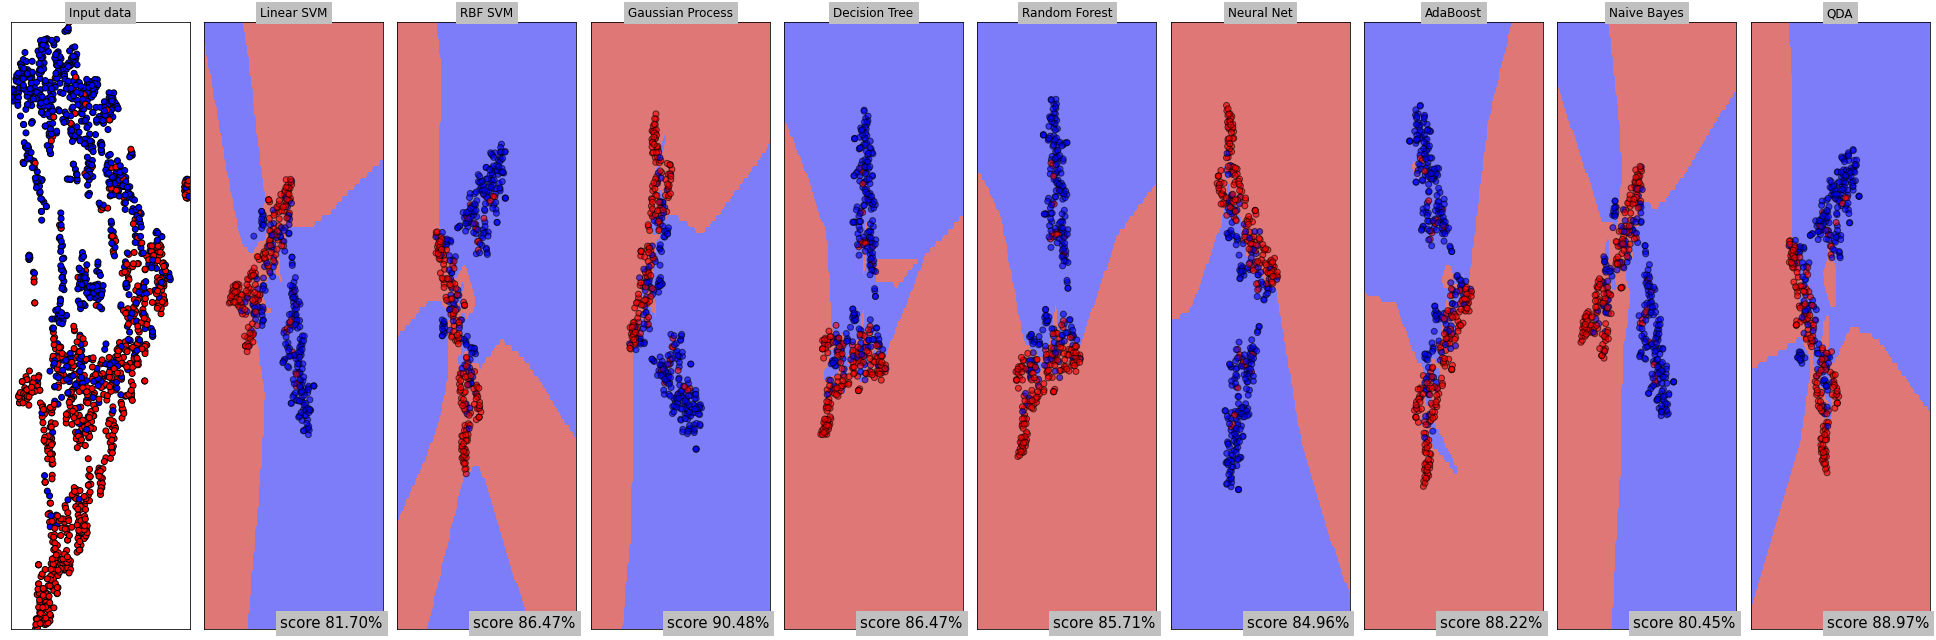

In [61]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

names = [
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

rng = np.random.RandomState(2)

figure = plt.figure(figsize=(27, 9))
i = 1

X_Train_embedded = TSNE(n_components=2).fit_transform(X_train)

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
cm_bright2 = ListedColormap(["#e07777", "#7d7dfa"])
ax = plt.subplot(1 , len(classifiers) + 1, i)
ax.set_title("Input data", backgroundcolor= 'silver')

# # Plot the training points
ax.scatter(X_Train_embedded[:, 0], X_Train_embedded[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_predicted = clf.predict(X_test)

    X_test_embedded = TSNE(n_components=2).fit_transform(X_test)

    # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_test_embedded, y_predicted) 
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

    #plot
    plt.contourf(xx, yy, voronoiBackground, cmap=cm_bright2)
    ax.scatter(X_test_embedded[:,0], X_test_embedded[:,1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name, backgroundcolor= 'silver')
    ax.text(
        xx.max() - 0.3,
        yy.min() + 0.3,
        ("score {:.2%}".format(score)).lstrip("0"),
        size=15,
        horizontalalignment="right",
        backgroundcolor='silver'
    )
    i += 1

plt.tight_layout()
plt.show()

As we can see, the Gaussian Process got the best score.

This is baseline performanace. It's not bad at all

Let's proceed to try improve it.

#### Gaussian Process

In [107]:
from sklearn.metrics import classification_report

clf = GaussianProcessClassifier(1.0 * RBF(1.0), random_state=123, n_jobs=-1)

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

results = classification_report(y_test, predictions)

print(results)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       173
           1       0.92      0.91      0.92       226

    accuracy                           0.90       399
   macro avg       0.90      0.90      0.90       399
weighted avg       0.91      0.90      0.90       399



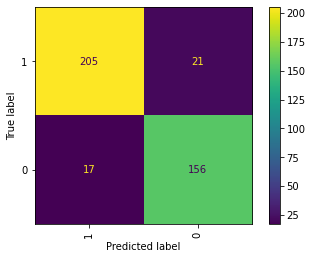

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions, labels=df.analytics.unique()), display_labels=df.analytics.unique())
cm.plot(xticks_rotation='vertical')
plt.show()

##### GridSearch

In [66]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_grid = [
    {'n_restarts_optimizer':[1,5,10]},
    {'max_iter_predict':[50,100,200]}
    ]

base_estimator = GaussianProcessClassifier(1.0 * RBF(1.0), random_state=123, n_jobs=-1)

sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                          factor=2).fit(X_train, y_train)

C:\Users\rodri\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\rodri\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\rodri\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\rodri\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:

The optimal v

In [71]:
sh.best_params_

{'max_iter_predict': 100}

In [222]:
clf = GaussianProcessClassifier(1.0 * RBF(1.0), random_state=123, n_jobs=-1, max_iter_predict=100)

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

results = classification_report(y_test, predictions)

print(results)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       173
           1       0.92      0.91      0.92       226

    accuracy                           0.90       399
   macro avg       0.90      0.90      0.90       399
weighted avg       0.91      0.90      0.90       399



No improvement. Let's Pickle it

In [223]:
with open("models\model_v1.pkl", "wb") as f:
    pickle.dump(clf, f)

Finnaly, we've made a function that can be used to predict new data.

The new data need to be processed to clean the text, and then create the embedding

In [109]:
def predict(text, w2vmodel=model, mlmodel=clf):
    if isinstance(text, str):
        text = pd.Series(text)
    
    embedding = CreateMatrix(w2vmodel)

    doc = embedding.get_matrix(text)
    predict = mlmodel.predict(doc)
    return predict[0]

In [111]:
predict('Data is the new oil')

1

To got better results we need a large corpus to improve the embedding. With a larger corpus we also could group documents by language and create a model for each language.

We also could try work on Word2Vec hyperparameters and/or try others ML Models.

A next step would be create a microsservice to consume this model.